In [2]:
%load_ext autoreload
%autoreload 2

In [88]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import utils
import pandas as pd
import seaborn as sns
from functools import partial
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from scipy import stats
import xarray

In [4]:
def gen_data(lam: float, n=1000):
    sigma = np.random.exponential(lam, size=n)
    a_bar = np.random.normal(0, 1.5, size=n)
    a = np.random.normal(a_bar, sigma, size=n)
    return a

<AxesSubplot:>

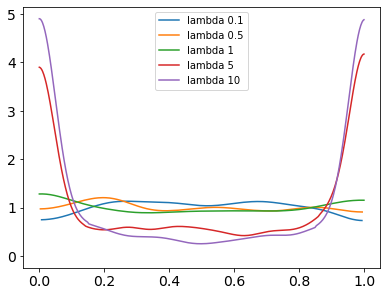

In [5]:
az.plot_dist(utils.sigmoid(gen_data(lam=.1,)), label="lambda 0.1", color="C0")
az.plot_dist(utils.sigmoid(gen_data(lam=.5,)), label="lambda 0.5", color="C1")
az.plot_dist(utils.sigmoid(gen_data(lam=1,)), label="lambda 1", color="C2")
az.plot_dist(utils.sigmoid(gen_data(lam=5,)), label="lambda 5", color="C3")
az.plot_dist(utils.sigmoid(gen_data(lam=10,)), label="lambda 10", color="C4")

In [6]:
df = pd.read_csv("data/reedfrogs.csv", sep=";")
df.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


In [7]:
df['size'] = pd.Categorical(df["size"], categories=["small", "big"], ordered=True)
df['pred'] = pd.Categorical(df["pred"], categories=["no", "pred"])
df['tank'] = df.index.values
df.head()

,density,pred,size,surv,propsurv,tank
0,10,no,big,9,0.9,0
1,10,no,big,10,1.0,1
2,10,no,big,7,0.7,2
3,10,no,big,10,1.0,3
4,10,no,small,9,0.9,4


In [8]:
coords = {
    "tanks_dim": df.tank
}

with pm.Model(coords=coords) as model1:
    sigma = pm.Exponential("sigma", 1)
    a_bar = pm.Normal("a_bar", mu=0, sigma=1.5)
    a = pm.Normal("a", mu=a_bar, sigma=sigma, dims="tanks_dim")

    p = pm.Deterministic("p", pm.math.sigmoid(a[df.tank]))

    pm.Binomial("surv_hat", n=df.density, p=p, observed=df.surv)

    trace1 = pm.sample(draws=500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, a_bar, a]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 2 seconds.


In [14]:
coords = {
    "tanks_dim": df.tank,
    "pred_dim": df.pred.cat.categories,
    "size_dim": df["size"].cat.categories
}

size_idx = df["size"].cat.codes
pred_idx = df.pred.cat.codes

with pm.Model(coords=coords) as model2:
    sigma = pm.Exponential("sigma", 1)
    alpha = pm.Normal("alpha", mu=0, sigma=sigma, dims="tanks_dim")
    beta = pm.Normal("beta", mu=0, sigma=1, dims=("pred_dim", "size_dim"))

    p = pm.Deterministic("p", pm.math.sigmoid(alpha[df.tank] + beta[pred_idx, size_idx]))

    pm.Binomial("surv_hat", n=df.density, p=p, observed=df.surv)

    trace2 = pm.sample(draws=2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.


In [15]:
az.summary(trace2, var_names=["beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[no, small]",2.371,0.306,1.803,2.950,0.004,0.003,5419.0,5663.0,1.0
"beta[no, big]",2.505,0.306,1.956,3.099,0.004,0.003,5889.0,5667.0,1.0
"beta[pred, small]",0.445,0.248,-0.024,0.910,0.004,0.003,3583.0,4085.0,1.0
"beta[pred, big]",-0.427,0.256,-0.903,0.044,0.004,0.003,3418.0,5095.0,1.0
sigma,0.731,0.146,0.482,1.017,0.003,0.002,1763.0,2930.0,1.0


In [11]:
az.compare({"model1": trace1, "model2": trace2})

/Users/alvaro/miniforge3/envs/rethinking/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/alvaro/miniforge3/envs/rethinking/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model2,0,-105.402435,26.364410,0.000000,0.755277,4.374409,0.000000,True,log
model1,1,-107.331542,27.985587,1.929107,0.244723,4.515485,2.989461,True,log


In [180]:
coords = {
    "tanks_dim": df.tank,
    "pred_dim": df.pred.cat.categories,
    "size_dim": df["size"].cat.categories
}

size_idx = df["size"].cat.codes
pred_idx = df.pred.cat.codes

with pm.Model(coords=coords) as model3:
    sigma = pm.Exponential("sigma", 1)
    alpha = pm.Normal("alpha", mu=0, sigma=sigma, dims="tanks_dim")
    beta = pm.Normal("beta", mu=0, sigma=1, dims=("pred_dim", "size_dim"))
    betaD = pm.Normal("betaD", mu=0, sigma=0.5, dims=("pred_dim"))

    density = pm.math.log(df.density)
    p = pm.math.sigmoid(alpha[df.tank] + beta[pred_idx, size_idx] + betaD[pred_idx]*density)
    p = pm.Deterministic("p", p)
    pm.Binomial("surv_hat", n=df.density, p=p, observed=df.surv)

    trace3 = pm.sample(draws=4000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta, betaD]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 21 seconds.


In [181]:
az.summary(trace3, var_names=["beta", "betaD", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[no, small]",0.622,0.630,-0.573,1.799,0.006,0.004,13099.0,11872.0,1.0
"beta[no, big]",0.772,0.633,-0.441,1.945,0.005,0.004,13254.0,12201.0,1.0
"beta[pred, small]",1.232,0.590,0.096,2.297,0.006,0.004,10628.0,11761.0,1.0
"beta[pred, big]",0.358,0.592,-0.719,1.509,0.006,0.004,10529.0,11888.0,1.0
betaD[no],0.610,0.196,0.246,0.978,0.002,0.001,12212.0,10963.0,1.0
betaD[pred],-0.269,0.183,-0.617,0.070,0.002,0.001,9644.0,10654.0,1.0
sigma,0.685,0.145,0.410,0.947,0.002,0.002,3926.0,5288.0,1.0


In [182]:
num = 20
density = [10,35,10,35]*20
density_std = np.log(density) # (density - np.mean(density)) / np.std(density)
size = pd.Categorical(["small", "small", "big", "big"]*20, categories=["small", "big"])
pred = pd.Categorical(["pred"]*4*20, categories=["no", "pred"])

In [183]:
aT = [
    np.random.normal(0, trace3.posterior["sigma"][0], size=(4000))
    for i in range(len(density))
]

In [184]:
p1 = [
    aT[i] + \
    trace3.posterior["beta"][0][:, pred.codes[i], size.codes[i]] + \
    trace3.posterior["betaD"][0][:, pred.codes[i]]*density_std[i]
    for i in range(len(density))
]

intervention = pd.Categorical(["no"]*4*20, categories=["no", "pred"])
p2 = [
    aT[i] + \
    trace3.posterior["beta"][0][:, intervention.codes[i], size.codes[i]] + \
    trace3.posterior["betaD"][0][:, intervention.codes[i]]*density_std[i]
    for i in range(len(density))
]

Text(0.5, 1.0, 'contrast')

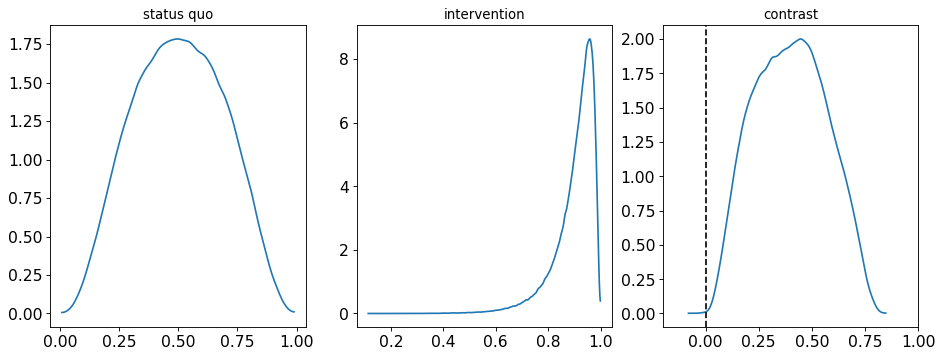

In [192]:
plt.figure(figsize=(14,5), dpi=80)
plt.subplot(1, 3, 1)
az.plot_dist(
    utils.sigmoid(np.concatenate([x.to_numpy() for x in p1], axis=0))
)
plt.title("status quo")

plt.subplot(1, 3, 2)
az.plot_dist(
    utils.sigmoid(np.concatenate([x.to_numpy() for x in p2], axis=0))
)
plt.title("intervention")

plt.subplot(1, 3, 3)
contrast = utils.sigmoid(np.concatenate([x.to_numpy() for x in p2], axis=0)) - \
           utils.sigmoid(np.concatenate([x.to_numpy() for x in p1], axis=0))
az.plot_dist(contrast)
plt.xlim(-0.2, 1)
plt.axvline(0, color="black", linestyle="--")
plt.title("contrast")